*This notebook bring everything together, we attempt to compare the sentiment data off reddit with the atlas data which we collect*

In [201]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [202]:
import os 
import pandas as pd

text_bodies = []
data_directory = './Labeled_Sentiment'
for filename in os.listdir(data_directory):
    f = os.path.join(data_directory, filename)
    if os.path.isfile(f):
        parser_df = pd.read_csv(f, keep_default_na=False, sep=',')
        for index, row in parser_df.iterrows():
            if 'body' in row:
                text_bodies.append(row['body'])
            elif 'title_text_combined' in row:
                text_bodies.append(row['title_text_combined'])
            else:
                print (f'Row {index} has no body or title_text_combined row!')
            if not isinstance(text_bodies[-1], str):
                print (row)
                print (len(text_bodies))

/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3441: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


We will not parse the files in the data directory, and store the resulting text bodies in text_bodies. For comments, we add the column 'body' and for posts we add the column 'title_text_combined'

In [203]:
import pandas as pd
from Sentiment_Analysis.sentiment_enum import LABEL_TO_NUM

data = pd.read_csv('./labeled_sentiment/comments_with_sentiment.csv')

sentiment_labels = []
failed = 0
for i in range(len(data)):
    try:
        sentiment_label = data['predicted_label'][i]
        sentiment_labels.append(LABEL_TO_NUM[sentiment_label])
    except:
        sentiment_labels.append(0)
        failed += 1

print (f'Failed on {failed} sentiment labels.')
print (f'Length of dataset: {len(sentiment_labels)}')

Failed on 712 sentiment labels.
Length of dataset: 239422


We will now run entity extraction on the text_bodies list, and store the entities for each post/comment into entity_labels

In [204]:
from Entity_Extraction.entity_extraction import EntityExtractor
entityExtractor = EntityExtractor()
entity_labels = entityExtractor.batch_extract(text_bodies)

KeyboardInterrupt: 

In [207]:
import pandas as pd

data = pd.read_csv('./Entity_Extraction/entities.csv')

entity_labels = []
failed = 0
for i in range(len(data)):
    entity_label = data['entity'][i]
    if entity_label == 'NONE':
        entity_labels.append([])
    else:
        entity_labels.append([entity_label])

print (f'Length of dataset: {len(entity_labels)}')

Length of dataset: 239422


Now, we will assign average sentiment to each entity. We first match each entity with the sentiment of all posts it is seen in. Then, we calculate an average for the sentiment of that label.

In [208]:
entity_sentiment_dict = dict()
for index in range(len(sentiment_labels)):
    temp_entities = entity_labels[index]
    temp_sentiment = sentiment_labels[index]

    for e in temp_entities:
        if e not in entity_sentiment_dict:
            entity_sentiment_dict[e] = []
        entity_sentiment_dict[e].append(temp_sentiment)

to_del = []
for e in entity_sentiment_dict:
    new_e_s = []
    for x in entity_sentiment_dict[e]:
        if x != 0:
            new_e_s.append(x)
    if len(new_e_s) == 0:
        to_del.append(e)
    else:
        entity_sentiment_dict[e] = \
            (len(new_e_s), sum(new_e_s)/len(new_e_s))
for i in to_del:
    del entity_sentiment_dict[i]

Run the following two cells to get some summaries of the data and a sense of what they contain

In [209]:
entity_sentiment_arr = sorted(entity_sentiment_dict.items(), key=lambda x:x[1][1])
[x for x in entity_sentiment_arr if x[1][0] >= 10]

[('EECS 496', (57, -0.6491228070175439)),
 ('CHEM 216', (16, -0.625)),
 ('EECS 477', (16, -0.625)),
 ('PHYSICS 235', (25, -0.6)),
 ('ECON 251', (15, -0.4666666666666667)),
 ('BE 100', (34, -0.35294117647058826)),
 ('STATS 280', (16, -0.25)),
 ('MATH 215', (201, -0.23383084577114427)),
 ('EECS 484', (35, -0.14285714285714285)),
 ('EECS 381', (25, -0.12)),
 ('CHEM 351', (22, -0.09090909090909091)),
 ('MATH 216', (105, -0.08571428571428572)),
 ('EECS 370', (391, -0.0792838874680307)),
 ('STATS 306', (13, -0.07692307692307693)),
 ('CHEM 215', (73, -0.0684931506849315)),
 ('BIO 305', (17, -0.058823529411764705)),
 ('EECS 376', (320, -0.0375)),
 ('ECON 102', (29, -0.034482758620689655)),
 ('ECON 401', (61, -0.01639344262295082)),
 ('SPANISH 232', (36, 0.0)),
 ('SPANISH 231', (12, 0.0)),
 ('ASTRO 102', (22, 0.0)),
 ('EECS 482', (182, 0.03296703296703297)),
 ('EECS 489', (27, 0.037037037037037035)),
 ('EECS 215', (40, 0.05)),
 ('STATS 425', (15, 0.06666666666666667)),
 ('CHEM 230', (15, 0.0666

In [210]:
entity_sentiment_arr = sorted(entity_sentiment_dict.items(), key=lambda x:x[1][1], reverse=True)
([x for x in entity_sentiment_arr if x[1][0] >= 10])

[('PAT 305', (16, 1.0)),
 ('EARTH 113', (17, 1.0)),
 ('LING 111', (12, 1.0)),
 ('ENGLISH 325', (13, 0.8461538461538461)),
 ('HISTORY 244', (11, 0.8181818181818182)),
 ('POLSCI 101', (11, 0.8181818181818182)),
 ('SLAVIC 312', (24, 0.75)),
 ('SPACE 101', (16, 0.75)),
 ('PHIL 183', (14, 0.7142857142857143)),
 ('MATH 201', (14, 0.7142857142857143)),
 ('SOC 100', (14, 0.7142857142857143)),
 ('ENGR 110', (13, 0.6923076923076923)),
 ('PHYSICS 360', (12, 0.6666666666666666)),
 ('SI 206', (11, 0.6363636363636364)),
 ('EECS 481', (16, 0.625)),
 ('SI 410', (10, 0.6)),
 ('MATH 156', (13, 0.5384615384615384)),
 ('ASTRO 101', (30, 0.5333333333333333)),
 ('GERMAN 386', (21, 0.5238095238095238)),
 ('PSYCH 111', (40, 0.5)),
 ('CLCIV 385', (20, 0.5)),
 ('MATH 120', (12, 0.5)),
 ('EARTH 100', (12, 0.5)),
 ('MCDB 310', (46, 0.4782608695652174)),
 ('EECS 270', (19, 0.47368421052631576)),
 ('MATH 295', (34, 0.47058823529411764)),
 ('EECS 201', (33, 0.45454545454545453)),
 ('BIO 225', (22, 0.4545454545454545

Find the list of courses with at least 50 appearances

In [219]:
print([x[0] for x in entity_sentiment_arr if x[1][0] >= 25])
print(len([x[0] for x in entity_sentiment_arr if x[1][0] >= 25]))

['ASTRO 101', 'PSYCH 111', 'MCDB 310', 'MATH 295', 'EECS 201', 'EECS 285', 'EECS 493', 'EECS 486', 'MATH 425', 'PHYSICS 340', 'EECS 491', 'ENGR 100', 'EECS 475', 'ENGLISH 125', 'SI 110', 'EECS 183', 'EECS 445', 'EECS 494', 'ECON 101', 'PHYSICS 140', 'PHYSICS 240', 'STATS 412', 'MATH 217', 'MATH 116', 'EECS 442', 'PHYSICS 135', 'EECS 485', 'EECS 490', 'CHEM 210', 'MATH 115', 'EECS 492', 'MATH 214', 'EECS 388', 'ANTHRCUL 101', 'EECS 280', 'CHEM 130', 'BIO 172', 'BIO 173', 'ENGR 101', 'EECS 203', 'CHEM 125', 'EECS 216', 'STATS 250', 'EECS 281', 'EECS 215', 'EECS 489', 'EECS 482', 'SPANISH 232', 'ECON 401', 'ECON 102', 'EECS 376', 'CHEM 215', 'EECS 370', 'MATH 216', 'EECS 381', 'EECS 484', 'MATH 215', 'BE 100', 'PHYSICS 235', 'EECS 496']
60


Test the sentiment against increased interest

In [236]:
import json
 
with open('Atlas/Atlas_Data_2.json') as json_file:
    atlas_data_json = json.load(json_file)

class_order = list(atlas_data_json.keys())
combined_data = {'expectations':[], 'desire':[], 'increased-interest':[], 'understanding':[], 'average':[], 'workload':[],'sentiment':[]}
for c in class_order:
    if entity_sentiment_dict[c][0] >= 25:
        temp_av = 0
        for dt in atlas_data_json[c]:
            if dt in ['desire', 'increased-interest', 'understanding']:
                temp_av += atlas_data_json[c][dt] * 0.01
            combined_data[dt].append(0.01 * atlas_data_json[c][dt])
        combined_data['average'].append(temp_av)
        combined_data['sentiment'].append(entity_sentiment_dict[c][1])

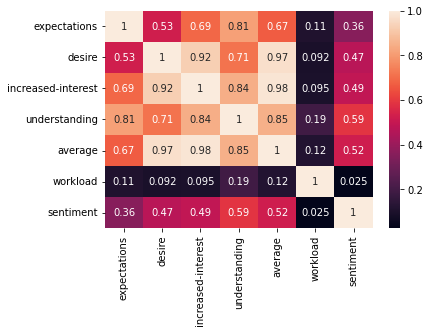

In [237]:
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt

df = pd.DataFrame(combined_data)
corr_matrix = df.corr()
sn.heatmap(corr_matrix, annot=True)
plt.show()

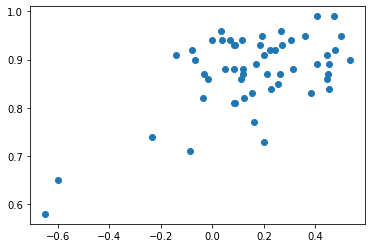

In [238]:
import matplotlib.pyplot as plt

x_points = combined_data['sentiment']
y_points = combined_data['understanding']

plt.plot(x_points, y_points, 'o')
plt.show()

In [231]:
import numpy as np
s = np.array(combined_data['sentiment'])
a = np.array(combined_data['understanding'])
fit = np.polyfit(s, a, 3)
v = np.polyval(fit, s)
np.mean(np.square(a - v))

0.0032421532793572043

In [232]:
np.corrcoef(s, a)

array([[1.        , 0.58831316],
       [0.58831316, 1.        ]])